## Unsupervised

In [1]:
import numpy as np
import librosa
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
def extract_features_robust(file_path):
    """Robust feature extraction with silence trimming"""
    # Load and trim silence
    y, sr = librosa.load(file_path, sr=None)
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)
    
    if len(y_trimmed) == 0:
        print(f"Warning: {file_path} is mostly silent, using original")
        y_trimmed = y
    
    y_trimmed = librosa.util.normalize(y_trimmed)
    
    # Compute features
    S = np.abs(librosa.stft(y_trimmed, n_fft=2048, hop_length=512))
    centroid = librosa.feature.spectral_centroid(S=S, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(S=S, sr=sr, roll_percent=0.85)
    
    return np.mean(centroid), np.mean(rolloff)

In [5]:
# =================== MAIN CODE ===================

# Update this path to your mixed folder
mixed_dir = "./dataset/mixed/"

features = []
file_paths = []

print("=== Processing Mixed Sound Files ===")
# Get all .wav files from mixed directory
mixed_files = list(Path(mixed_dir).glob("*.wav"))

for i, audio_file in enumerate(mixed_files, 1):
    try:
        centroid, rolloff = extract_features_robust(str(audio_file))
        features.append([centroid, rolloff])
        file_paths.append(str(audio_file))
        print(f"  [{i:2d}] {audio_file.name}: C={centroid:.0f} Hz, R={rolloff:.0f} Hz")
    except Exception as e:
        print(f"  Error processing {audio_file.name}: {e}")

print(f"\nProcessed {len(features)} files total")

if len(features) < 2:
    print("\nERROR: Need at least 2 files for clustering!")
    exit()

# Convert to numpy array
features = np.array(features)

# Standardize features (important for clustering)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply K-Means clustering (assuming 2 clusters: bird and dog)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(features_scaled)

# Get cluster centers in original scale
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Analyze which cluster is likely birds vs dogs
# Based on spectral properties: higher centroid/rolloff = birds
cluster_labels = ["Bird", "Dog"]  # We'll determine which is which

# Determine which cluster has higher average centroid (likely birds)
if np.mean(features[clusters == 0, 0]) > np.mean(features[clusters == 1, 0]):
    # Cluster 0 has higher centroid -> likely birds
    cluster_names = {0: "Bird", 1: "Dog"}
else:
    # Cluster 1 has higher centroid -> likely birds
    cluster_names = {1: "Bird", 0: "Dog"}

print("\n" + "="*60)
print("CLUSTERING RESULTS")
print("="*60)

# Count files in each cluster
cluster_0_indices = np.where(clusters == 0)[0]
cluster_1_indices = np.where(clusters == 1)[0]

print(f"\nCluster 0 ({cluster_names[0]}): {len(cluster_0_indices)} files")
print(f"  Mean Centroid: {np.mean(features[cluster_0_indices, 0]):.0f} Hz")
print(f"  Mean Roll-off: {np.mean(features[cluster_0_indices, 1]):.0f} Hz")

print(f"\nCluster 1 ({cluster_names[1]}): {len(cluster_1_indices)} files")
print(f"  Mean Centroid: {np.mean(features[cluster_1_indices, 0]):.0f} Hz")
print(f"  Mean Roll-off: {np.mean(features[cluster_1_indices, 1]):.0f} Hz")

# Show which files belong to which cluster
print(f"\n" + "="*60)
print("FILE ASSIGNMENTS TO CLUSTERS")
print("="*60)

print(f"\nCluster {cluster_names[0]} files:")
for idx in cluster_0_indices[:]:
    file_name = Path(file_paths[idx]).name
    print(f"  {file_name}: C={features[idx, 0]:.0f} Hz, R={features[idx, 1]:.0f} Hz")

print(f"\nCluster {cluster_names[1]} files:")
for idx in cluster_1_indices[:]:
    file_name = Path(file_paths[idx]).name
    print(f"  {file_name}: C={features[idx, 0]:.0f} Hz, R={features[idx, 1]:.0f} Hz")

# Evaluate clustering quality (Silhouette Score)
from sklearn.metrics import silhouette_score
if len(np.unique(clusters)) > 1:
    silhouette_avg = silhouette_score(features_scaled, clusters)
    print(f"\n" + "="*60)
    print("CLUSTERING QUALITY METRICS")
    print("="*60)
    print(f"Silhouette Score: {silhouette_avg:.3f}")
    print("(Closer to 1.0 = better separation between clusters)")

=== Processing Mixed Sound Files ===
  [ 1] 101427-8.wav: C=3595 Hz, R=5642 Hz
  [ 2] 101308-10.wav: C=3611 Hz, R=5071 Hz
  [ 3] 101308-11.wav: C=3644 Hz, R=5053 Hz
  [ 4] 101427-9.wav: C=4024 Hz, R=5280 Hz
  [ 5] 101308-13.wav: C=3656 Hz, R=5578 Hz
  [ 6] 101308-9.wav: C=3763 Hz, R=4906 Hz
  [ 7] 101308-8.wav: C=3399 Hz, R=4894 Hz
  [ 8] 101308-12.wav: C=4075 Hz, R=5044 Hz
  [ 9] dog_11.wav: C=1147 Hz, R=1730 Hz
  [10] 102948-1.wav: C=3689 Hz, R=5392 Hz
  [11] 102948-0.wav: C=3930 Hz, R=5509 Hz
  [12] dog_10.wav: C=1826 Hz, R=3465 Hz
  [13] dog_12.wav: C=1317 Hz, R=2131 Hz
  [14] 102948-2.wav: C=2788 Hz, R=4901 Hz
  [15] dog_13.wav: C=833 Hz, R=1061 Hz
  [16] dog_17.wav: C=2849 Hz, R=4967 Hz
  [17] 102948-6.wav: C=2669 Hz, R=4795 Hz
  [18] dog_16.wav: C=2228 Hz, R=3707 Hz
  [19] dog_8.wav: C=1580 Hz, R=2492 Hz
  [20] dog_14.wav: C=1840 Hz, R=3278 Hz
  [21] dog_28.wav: C=1284 Hz, R=1884 Hz
  [22] 102948-4.wav: C=3987 Hz, R=5577 Hz
  [23] 102948-5.wav: C=3744 Hz, R=5436 Hz
  [24] dog_29

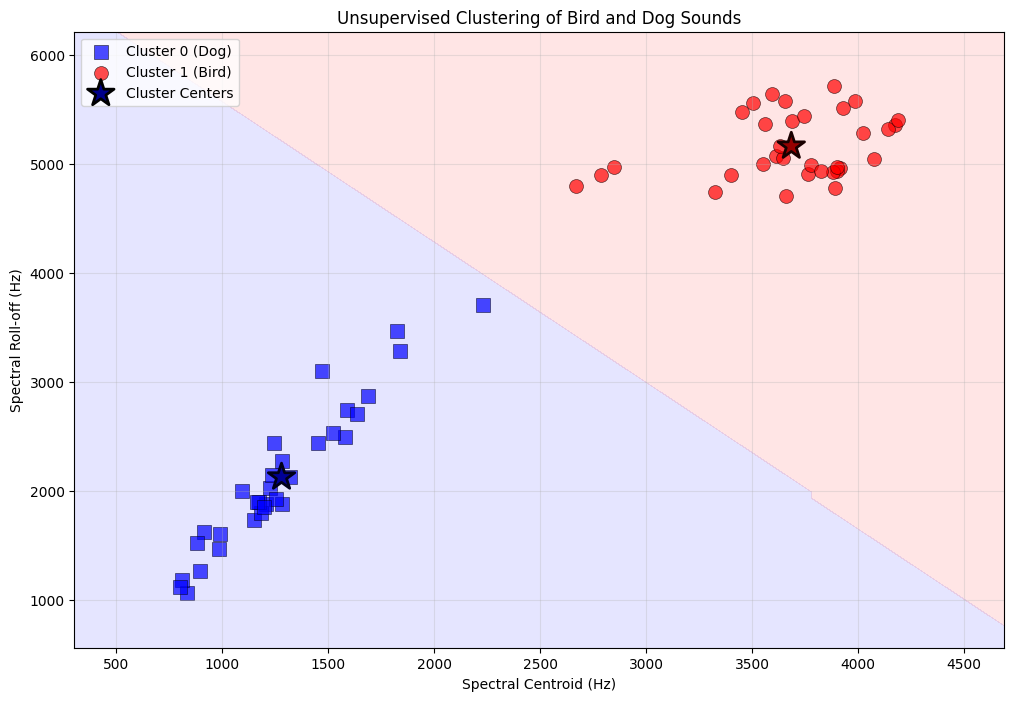

In [6]:
# Visualization
def plot_clusters(features, clusters, cluster_names, cluster_centers):
    """Visualize the clustering results"""
    plt.figure(figsize=(12, 8))
    
    # Plot points colored by cluster
    colors = ['blue', 'red']
    
    for cluster_id in [0, 1]:
        cluster_points = features[clusters == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                    c=colors[cluster_id], marker='o' if cluster_names[cluster_id] == "Bird" else 's',
                    s=100, alpha=0.7, label=f'Cluster {cluster_id} ({cluster_names[cluster_id]})',
                    edgecolors='black', linewidth=0.5)
    
    # Plot cluster centers
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
                c=['darkblue', 'darkred'], marker='*', s=400,
                label='Cluster Centers', edgecolors='black', linewidth=2)
    
    # Plot decision boundary (for visualization)
    # Create a mesh grid
    x_min, x_max = features[:, 0].min() - 500, features[:, 0].max() + 500
    y_min, y_max = features[:, 1].min() - 500, features[:, 1].max() + 500
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                        np.linspace(y_min, y_max, 100))
    
    # Scale the mesh grid points
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    mesh_points_scaled = scaler.transform(mesh_points)
    
    # Predict cluster for each mesh point
    Z = kmeans.predict(mesh_points_scaled)
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.1, colors=colors, levels=[-0.5, 0.5, 1.5])
    
    plt.xlabel('Spectral Centroid (Hz)')
    plt.ylabel('Spectral Roll-off (Hz)')
    plt.title('Unsupervised Clustering of Bird and Dog Sounds')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Visualize the clustering
plot_clusters(features, clusters, cluster_names, cluster_centers)